# Predicting the Outcome of Cricket Matches

## Introduction

In this project, we shall build a model which predicts the outcome of cricket matches in the Indian Premier League using data about matches and deliveries.

### Data Mining:

  * Season : 2008 - 2015 (8 Seasons)
  * Teams : DD, KKR, MI, RCB, KXIP, RR, CSK (7 Teams)
  * Neglect matches that have inconsistencies such as No Result, Tie, D/L Method, etc.

### Possible Features:

  * Average Batsman Rating (top 5) 
  * Average Bowler Rating (top 4)
  * Player of the match frequency 
  * Previous Encounter - Win by runs, Win by Wickets 
  * Recent form (Last 5 Games)
  * Venue - Home, Away, Neutral

In [2]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
from __future__ import division

## Data Mining
  

In [3]:
# Reading in the data
allmatches = pd.read_csv("../data/matches.csv")
alldeliveries = pd.read_csv("../data/deliveries.csv")
allmatches.head(10)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,5,2008,Kolkata,2008-04-20,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN
5,6,2008,Jaipur,2008-04-21,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,bat,normal,0,Rajasthan Royals,0,6,SR Watson,Sawai Mansingh Stadium,Aleem Dar,RB Tiffin,NaN
6,7,2008,Hyderabad,2008-04-22,Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,normal,0,Delhi Daredevils,0,9,V Sehwag,"Rajiv Gandhi International Stadium, Uppal",IL Howell,AM Saheba,NaN
7,8,2008,Chennai,2008-04-23,Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,normal,0,Chennai Super Kings,6,0,ML Hayden,"MA Chidambaram Stadium, Chepauk",DJ Harper,GA Pratapkumar,NaN
8,9,2008,Hyderabad,2008-04-24,Deccan Chargers,Rajasthan Royals,Rajasthan Royals,field,normal,0,Rajasthan Royals,0,3,YK Pathan,"Rajiv Gandhi International Stadium, Uppal",Asad Rauf,MR Benson,NaN
9,10,2008,Chandigarh,2008-04-25,Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,normal,0,Kings XI Punjab,66,0,KC Sangakkara,"Punjab Cricket Association Stadium, Mohali",Aleem Dar,AM Saheba,NaN


In [4]:
# Selecting Seasons 2008 - 2015
matches_seasons = allmatches.loc[allmatches['season'] != 2016]
deliveries_seasons = alldeliveries.loc[alldeliveries['match_id'] < 518]

In [5]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_teams = matches_seasons.loc[(matches_seasons['team1'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab'])) & (matches_seasons['team2'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab']))]
matches_teams.team1.unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
       'Delhi Daredevils'], dtype=object)

In [6]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_team_matchids = matches_teams.id.unique()
deliveries_teams = deliveries_seasons.loc[deliveries_seasons['match_id'].isin(matches_team_matchids)]
deliveries_teams.batting_team.unique()

array(['Kolkata Knight Riders', 'Royal Challengers Bangalore',
       'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
       'Delhi Daredevils', 'Mumbai Indians'], dtype=object)

In [7]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches = matches_teams.loc[(matches_teams['result'] == 'normal') & (matches_teams['dl_applied'] == 0)]

In [8]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches_matchids = matches.id.unique()
deliveries = deliveries_teams.loc[deliveries_teams['match_id'].isin(matches_matchids)]

In [9]:
# Verifying consistency between datasets
(matches.id.unique() == deliveries.match_id.unique()).all()

True

# Building Features

In [10]:
# Team Strike rates for first 5 batsmen in the team (Higher the better)

def getMatchDeliveriesDF(match_id):
    return deliveries.loc[deliveries['match_id'] == match_id]

def getInningsOneBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()[0:5]

def getInningsTwoBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()[0:5]

def getBatsmanStrikeRate(batsman, match_id):
    onstrikedeliveries = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['batsman'] == batsman)]
    total_runs = onstrikedeliveries['batsman_runs'].sum()
    total_balls = onstrikedeliveries.shape[0]
    return (total_runs/total_balls) * 100

def getTeamStrikeRate(batsmen, match_id):
    strike_rates = []
    for batsman in batsmen:
        strike_rates.append(getBatsmanStrikeRate(batsman, match_id))
    return np.mean(strike_rates)

def getAverageStrikeRates(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneBatsmen(match_deliveries)
    innTwoBatsmen = getInningsTwoBatsmen(match_deliveries)
    teamOneSR = getTeamStrikeRate(innOneBatsmen, match_id)
    teamTwoSR = getTeamStrikeRate(innTwoBatsmen, match_id)
    return teamOneSR, teamTwoSR

In [11]:
# Testing Functionality
getAverageStrikeRates(517)


(126.98024523159935, 128.55579510411653)

In [12]:
# Bowler Rating : Wickets/Run (Higher the Better)
# Team 1: Batting First; Team 2: Fielding First

def getInningsOneBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()[0:4]

def getInningsTwoBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()[0:4]

def getBowlerWPR(bowler, match_id):
    balls = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['bowler'] == bowler)]
    total_runs = balls['total_runs'].sum()
    total_wickets = balls.loc[balls['dismissal_kind'].isin(['caught', 'bowled', 'lbw', \
    'caught and bowled', 'stumped'])].shape[0]
    return (total_wickets/total_runs) * 100

def getTeamWPR(bowlers, match_id):
    WPRs = []
    for bowler in bowlers:
        WPRs.append(getBowlerWPR(bowler, match_id))
    return np.mean(WPRs)

def getAverageWPR(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBowlers = getInningsOneBowlers(match_deliveries)
    innTwoBowlers = getInningsTwoBowlers(match_deliveries)
    teamOneWPR = getTeamWPR(innTwoBowlers, match_id)
    teamTwoWPR = getTeamWPR(innOneBowlers, match_id)
    return teamOneWPR, teamTwoWPR

In [13]:
#Testing Functionality 
getAverageWPR(517)

(2.7641806594085776, 4.4721111768026631)

In [14]:
# Man of the Match Awards for players of both Teams 

def getInningsOneAllBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()

def getInningsTwoAllBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()

def getInningsOneAllBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()

def getInningsTwoAllBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()

def getTeam(batsmen,bowlers):
    return np.append(batsmen,bowlers)

def getPlayerMVPAwards(player, match_id):
    return matches.loc[(matches["player_of_match"] == player) & (matches['id'] < match_id)].shape[0]

def getTeamMVPAwards(team, match_id):
    mvpAwards = 0
    for player in team:
        mvpAwards = mvpAwards + getPlayerMVPAwards(player,match_id)
    
    return mvpAwards

def bothTeamMVPAwards(match_id):
    matchDeliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneAllBatsmen(matchDeliveries)
    innTwoBatsmen = getInningsTwoAllBatsmen(matchDeliveries)
    innOneBowlers = getInningsTwoAllBowlers(matchDeliveries)
    innTwoBowlers = getInningsOneAllBowlers(matchDeliveries)
    team1 = getTeam(innOneBatsmen, innTwoBowlers)
    
    team2 = getTeam(innTwoBatsmen, innOneBowlers)
    team1Awards = getTeamMVPAwards(team1,match_id)
    team2Awards = getTeamMVPAwards(team2,match_id)
    return team1Awards, team2Awards

        

 



In [15]:
#Testing Functionality
bothTeamMVPAwards(517)

(35, 69)

In [16]:
#Function to generate squad rating 

def generateSquadRating(match_id):
    gameday_teams = deliveries.loc[(deliveries['match_id'] == match_id)].batting_team.unique()
    teamOne = gameday_teams[0]
    teamTwo = gameday_teams[1]
    teamOneSR, teamTwoSR = getAverageStrikeRates(match_id)
    teamOneWPR, teamTwoWPR = getAverageWPR(match_id)
    teamOneMVPs, teamTwoMVPs = bothTeamMVPAwards(match_id)
    print "Comparing squads for {} vs {}".format(teamOne,teamTwo)
    print "\nAverage Strike Rate for Batsmen in {} : {}".format(teamOne,teamOneSR)
    print "\nAverage Strike Rate for Batsmen in {} : {}".format(teamTwo,teamTwoSR)
    print "\nBowler Rating (W/R) for {} : {}".format(teamOne,teamOneWPR)
    print "\nBowler Rating (W/R) for {} : {}".format(teamTwo,teamTwoWPR)
    print "\nNumber of MVP Awards in {} : {}".format(teamOne,teamOneMVPs)
    print "\nNumber of MVP Awards in {} : {}".format(teamTwo,teamTwoMVPs)
     
generateSquadRating(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating (W/R) for Mumbai Indians : 2.76418065941

Bowler Rating (W/R) for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 35

Number of MVP Awards in Chennai Super Kings : 69


# graph test
men_means = (35)
men_std = (2)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r', yerr=men_std)

women_means = (69)
women_std = (3)
rects2 = ax.bar(ind + width, women_means, width, color='y', yerr=women_std)

ax.set_ylabel('Scores')
ax.set_title('Scores by match')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Match'))

ax.legend((rects1[0], rects2[0]), ('Team1', 'Team2'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [17]:
## 2nd Feature : Previous Encounter
# Won by runs and won by wickets (Higher the better)

def getTeam1(match_id):
    return matches.loc[matches["id"] == match_id].team1.unique()

def getTeam2(match_id):
    return matches.loc[matches["id"] == match_id].team2.unique()

def getPreviousEncDF(match_id):
    team1 = getTeam1(match_id)
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (((matches["team1"].isin(team1)) & (matches["team2"].isin(team2))) | ((matches["team1"].isin(team2)) & (matches["team2"].isin(team1))))]

def getTeamWBR(match_id, team):
    WBR = 0
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBR = winnerDF['win_by_runs'].sum()    
    return WBR


def getTeamWBW(match_id, team):
    WBW = 0 
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBW = winnerDF['win_by_wickets'].sum()
    return WBW 
    
def getBothTeamStats(match_id):
    DF = getPreviousEncDF(match_id)
    timesPlayed = DF.shape[0]
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    timesWon = DF.loc[DF["winner"] == team1].shape[0]
    WBRTeam1 = getTeamWBR(match_id, team1)
    WBRTeam2 = getTeamWBR(match_id, team2)
    WBWTeam1 = getTeamWBW(match_id, team1)
    WBWTeam2 = getTeamWBW(match_id, team2)

    print "{} and {} have played {} times in the past and {} have won {} times out of that.".format(team1, team2, timesPlayed, team1, timesWon)
    print "{} won by {} total runs and {} total wickets.".format(team1, WBRTeam1, WBWTeam1)
    print "{} won by {} total runs and {} total wickets.".format(team2, WBRTeam2, WBWTeam2)




In [18]:
#Testing functionality 
getBothTeamStats(503)


Royal Challengers Bangalore and Mumbai Indians have played 16 times in the past and Royal Challengers Bangalore have won 7 times out of that.
Royal Challengers Bangalore won by 45 total runs and 37 total wickets.
Mumbai Indians won by 203 total runs and 23 total wickets.


In [19]:
#3rd Feature: Recent Form (Win Percentage of all the previous matches of a team in the same season)
#Higher the better

def getMatchYear(match_id):
    return matches.loc[matches["id"] == match_id].season.unique()

def getTeam1DF(match_id, year):
    team1 = getTeam1(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team1)) | (matches["team2"].isin(team1)))].tail(5)

def getTeam2DF(match_id, year):
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team2)) | (matches["team2"].isin(team2)))].tail(5)

def getTeamWinPercentage(match_id):
    win = 0
    total = 0
    year = int(getMatchYear(match_id))
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    team1DF = getTeam1DF(match_id, year)
    team2DF = getTeam2DF(match_id, year)
    team1TotalMatches = team1DF.shape[0]
    team1WinMatches = team1DF.loc[team1DF["winner"] == team1].shape[0]
    team2TotalMatches = team2DF.shape[0]
    team2WinMatches = team2DF.loc[team2DF["winner"] == team2].shape[0]
    winPercTeam1 = (team1WinMatches / team1TotalMatches) * 100
    winPercTeam2 = (team2WinMatches / team2TotalMatches) * 100
    print "In the season of {}, {} has a win percentage of {}% and {} has a win percentage of {}% ".format(year, team1, winPercTeam1, team2, winPercTeam2)
    


In [20]:
#Function to implement all features
def getAllFeatures(match_id):
    generateSquadRating(match_id)
    print ("\n")
    getBothTeamStats(match_id)
    print("\n")
    getTeamWinPercentage(match_id)


In [21]:
#Testing Functionality
getAllFeatures(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating (W/R) for Mumbai Indians : 2.76418065941

Bowler Rating (W/R) for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 35

Number of MVP Awards in Chennai Super Kings : 69


Mumbai Indians and Chennai Super Kings have played 21 times in the past and Mumbai Indians have won 11 times out of that.
Mumbai Indians won by 144 total runs and 30 total wickets.
Chennai Super Kings won by 138 total runs and 31 total wickets.


In the season of 2015, Mumbai Indians has a win percentage of 80.0% and Chennai Super Kings has a win percentage of 60.0% 


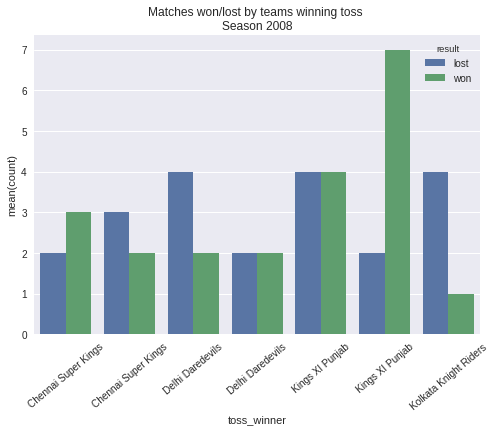

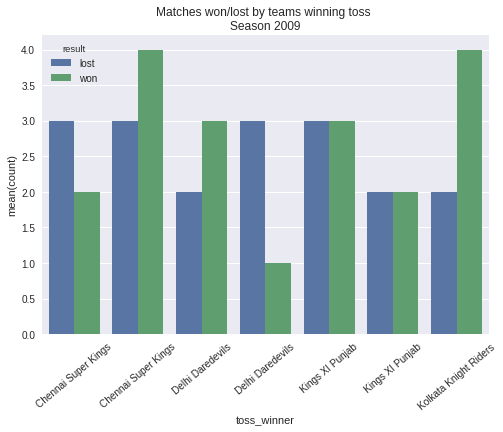

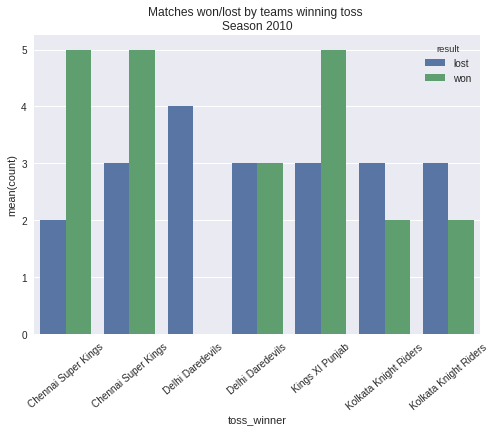

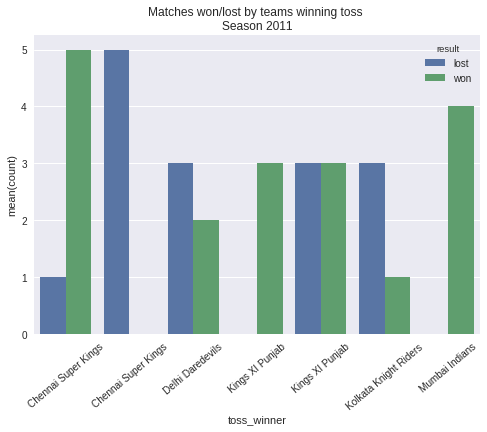

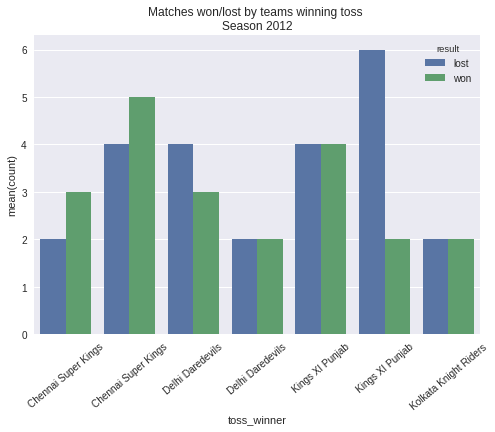

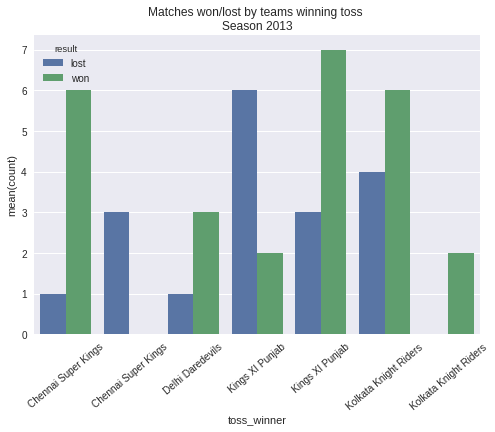

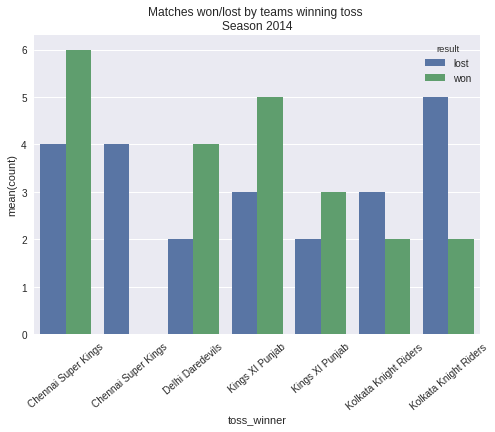

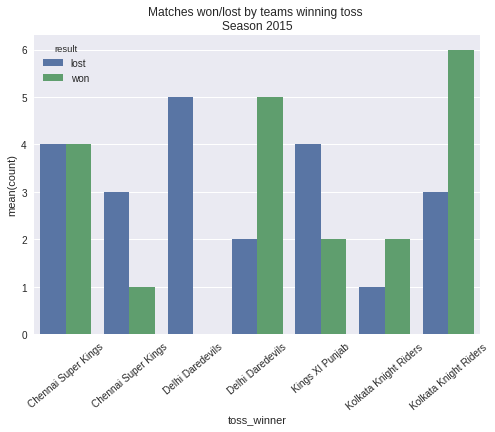

In [22]:
#toss effect
toss = matches.groupby(['season', 'toss_winner']).winner.value_counts().reset_index(name = 'count')
toss['result'] = np.where(toss.toss_winner == toss.winner, 'won', 'lost')
toss_result = toss.groupby(['season', 'toss_winner','result'])['count'].sum().reset_index()

for x in range(2008, 2016, 1):
    toss_result_x = toss_result[toss_result['season'] == x]
    plot = sns.barplot(x="toss_winner", y="count", hue="result", data=toss_result_x)
    plot.set_title('Matches won/lost by teams winning toss \nSeason ' +str(x))
    plot.set_xticklabels(toss_result_x['toss_winner'],rotation=40)
    plt.show()
    x+=1

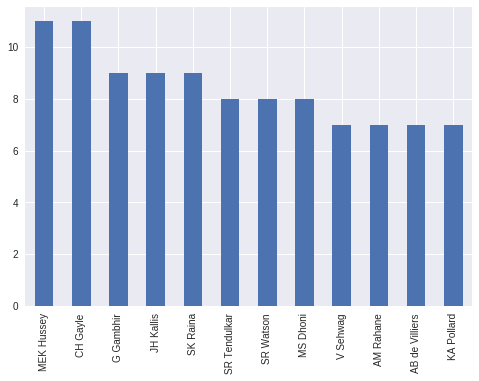

In [23]:
matches['player_of_match'].value_counts()[:12].plot(kind = 'bar')

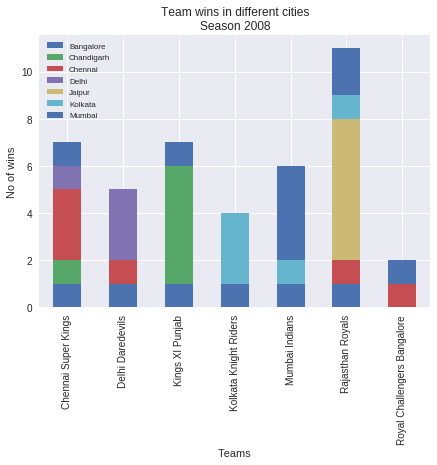

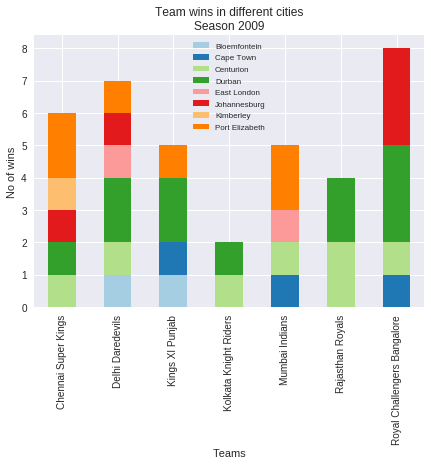

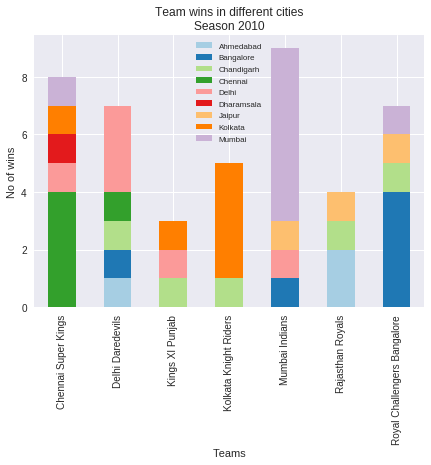

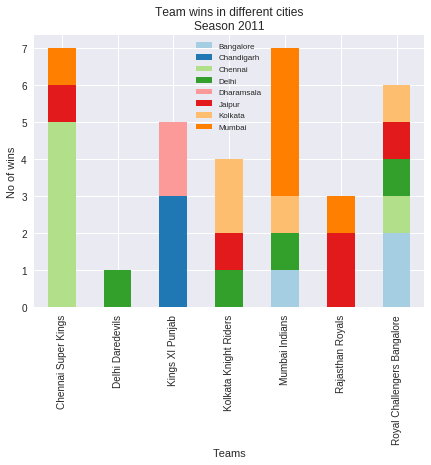

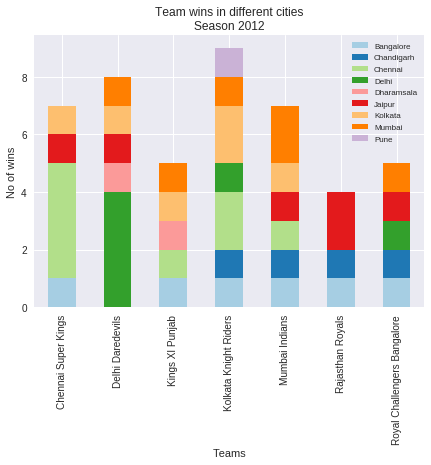

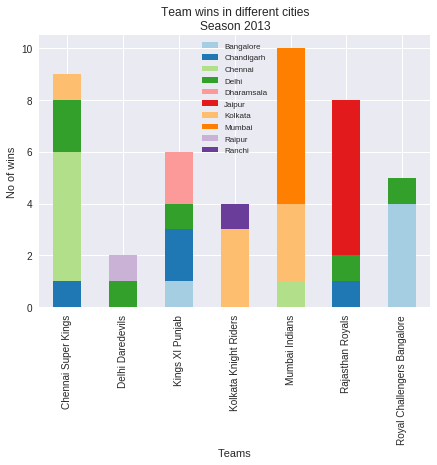

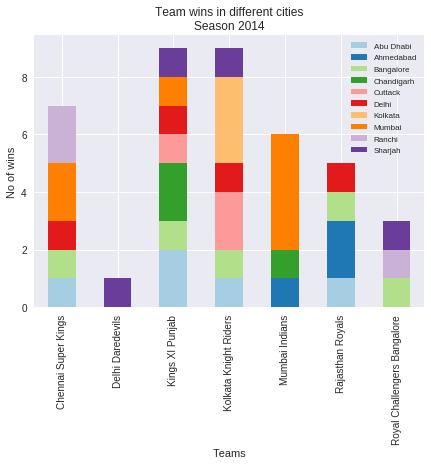

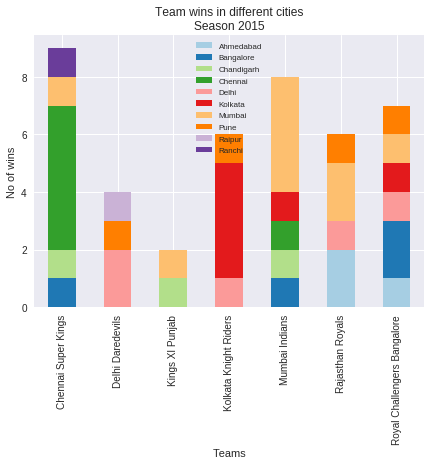

In [24]:
x, y = 2008, 2016
while x < y:
    wins_percity = matches[matches['season'] == x].groupby(['winner', 'city'])['id'].count().unstack()
    plot = wins_percity.plot(kind='bar', stacked=True, title="Team wins in different cities\nSeason "+str(x), figsize=(7, 5))
    sns.set_palette("Paired", len(matches['city'].unique()))
    plot.set_xlabel("Teams")
    plot.set_ylabel("No of wins")
    plot.legend(loc='best', prop={'size':8})
    x+=1

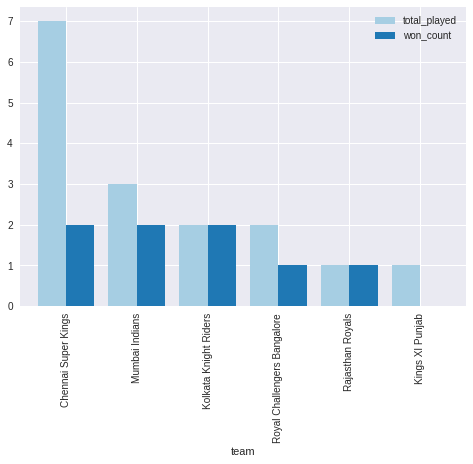

In [25]:
#Graphical Analysis of Team played and won Maximum final
finals=matches.drop_duplicates(subset=['season'],keep='last')
finals=finals[['id','season','city','team1','team2','toss_winner','toss_decision','winner']]
finals_played=pd.concat([finals['team1'],finals['team2']]).value_counts().reset_index()
finals_played.columns=[['team','count']]
abc=finals['winner'].value_counts().reset_index()
finals_played=finals_played.merge(abc,left_on='team',right_on='index',how='outer')
finals_played=finals_played.replace(np.NAN,0)
finals_played.drop('index',axis=1,inplace=True)
finals_played.set_index('team',inplace=True)
finals_played.columns=['total_played','won_count']
finals_played.plot.bar(width=0.8)
plt.show()





In [26]:
KKR_matches=matches[(matches['team1']=='Kolkata Knight Riders') | (matches['team2']=='Kolkata Knight Riders')]
DD_matches=matches[(matches['team1']=='Delhi Daredevils') | (matches['team2']=='Delhi Daredevils')]
RR_matches=matches[(matches['team1']=='Rajasthan Royals') | (matches['team2']=='Rajasthan Royals')]
KXIP_matches=matches[(matches['team1']=='Kings XI Punjab') | (matches['team2']=='Kings XI Punjab')]
RCB_matches=matches[(matches['team1']=='Royal Challengers Bangalore') |(matches['team2']=='Royal Challengers Bangalore')]
CSK_matches=matches[(matches['team1']=='Chennai Super Kings') |(matches['team2']=='Chennai Super Kings')]
MI_matches=matches[(matches['team1']=='Mumbai Indians') |(matches['team2']=='Mumbai Indians')]

Total_KKR=KKR_matches['id'].count()
Total_DD=DD_matches['id'].count()
Total_RR=RR_matches['id'].count()
Total_RCB=RCB_matches['id'].count()
Total_KXIP=KKR_matches['id'].count()
Total_CSK=CSK_matches['id'].count()
Total_MI=MI_matches['id'].count()

Total_DD

90

In [27]:
KKR_won=matches[matches['winner']=='Kolkata Knight Riders']
RCB_won=matches[matches['winner']=='Royal Challengers Bangalore']
MI_won=matches[matches['winner']=='Mumbai Indians']
RR_won=matches[matches['winner']=='Rajasthan Royals']
KXIP_won=matches[matches['winner']=='Kings XI Punjab']
CSK_won=matches[matches['winner']=='Chennai Super Kings']
DD_won=matches[matches['winner']=='Delhi Daredevils']

Total_KKR1=KKR_won['id'].count()
Total_DD1=DD_won['id'].count()
Total_RR1=RR_won['id'].count()
Total_RCB1=RCB_won['id'].count()
Total_CSK1=CSK_won['id'].count()
Total_MI1=MI_won['id'].count()
Total_KXIP1=KXIP_won['id'].count()

Total_DD1

36

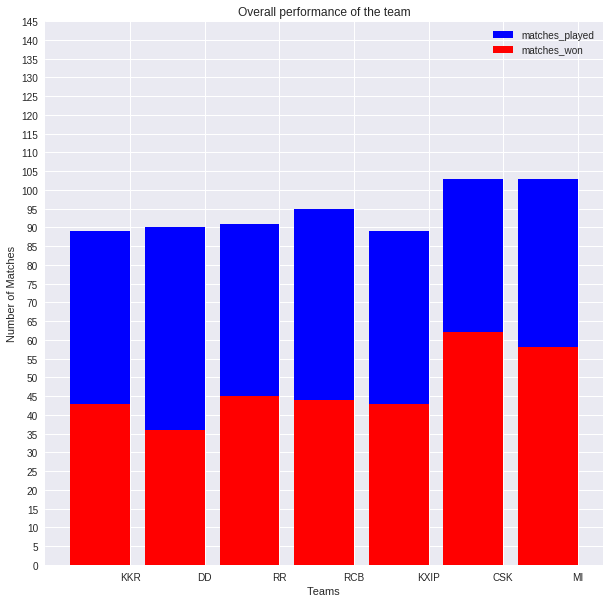

In [28]:
n_bins = 7
ind = np.arange(n_bins)
width = 0.80

plt.figure(figsize=(10,10))

matches_played=[Total_KKR,Total_DD,Total_RR,Total_RCB,Total_KXIP,Total_CSK,Total_MI]
matches_won=[Total_KKR1,Total_DD1,Total_RR1,Total_RCB1,Total_KXIP1,Total_CSK1,Total_MI1]

p1 = plt.bar(ind, matches_played, width, color='Blue')
p2 = plt.bar(ind, matches_won, width, color='Red')

plt.ylabel('Number of Matches')
plt.xlabel('Teams')
plt.title('Overall performance of the team')
plt.xticks(ind + width/2., ('KKR', 'DD', 'RR', 'RCB', 'KXIP', 'CSK', 'MI'))
plt.yticks(np.arange(0, 150, 5))
plt.legend((p1[0], p2[0]), ('matches_played', 'matches_won'))
